# Imports

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from monai.data import DataLoader, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    EnsureTyped
)
import sys
import os
from pathlib import Path
import torch
import glob


In [3]:
root_dir = Path(os.getcwd()).parent
sys.path.append(str(root_dir))
print(root_dir)

from src.data.transform import get_train_transforms
from src.models.unet import get_unet_model
from src.training.train import train_one_epoch, validate_one_epoch 
from src.utils.plotting import plot_loss_metrics, plot_segmentation_predictions

/Users/yannikfruehwirth/Desktop/coding/ct-segmentation-monai


In [3]:
# plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Data & Setup

In [4]:
data_dir = "../data/raw/Task07_Pancreas/imagesTr"
label_dir = "../data/raw/Task07_Pancreas/labelsTr"

In [5]:
# first sample
sample_filename = "pancreas_001.nii.gz"
img = nib.load(os.path.join(data_dir, sample_filename)) # lazy loading
label = nib.load(os.path.join(label_dir, sample_filename)) # lazy loading
# to numpy 
image_data = img.get_fdata() 
label_data = label.get_fdata()
# metadata
header = img.header
spacing = header.get_zooms()

# Sanity checks

## Sanity check for data transformation 
- see [transformation code](src/data/transform.py)

/Users/yannikfruehwirth/Desktop/coding/ct-segmentation-monai/.venv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Shape before transform: torch.Size([1, 512, 512, 110])
Shape after transform: torch.Size([1, 128, 128, 128])


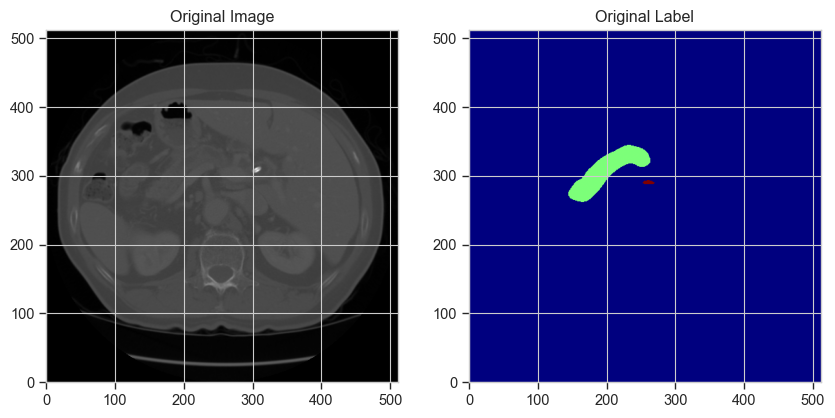

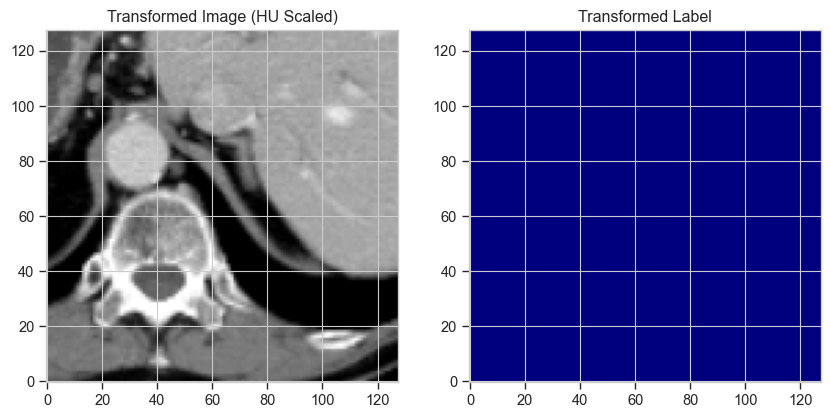

In [6]:
img_path = os.path.join(data_dir, sample_filename)
label_path = os.path.join(label_dir, sample_filename)

test_data = [{"image": img_path, "label": label_path}]

# "no transform" for visualization
base_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"])
])
base_ds = Dataset(data=test_data, transform=base_transforms)
base_data = base_ds[0]

check_ds = Dataset(data=test_data, transform=get_train_transforms())
check_data = check_ds[0]

print(f"Shape before transform: {base_data['image'].shape}")
print(f"Shape after transform: {check_data['image'].shape}")


# plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(base_data["image"][0, :, :, base_data["image"].shape[3]//2].T, cmap="gray", origin="lower")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(base_data["label"][0, :, :, base_data["label"].shape[3]//2].T, cmap="jet", origin="lower")
plt.title("Original Label")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(check_data["image"][0, :, :, check_data["image"].shape[3]//2].T, cmap="gray", origin="lower")
plt.title("Transformed Image (HU Scaled)")
plt.subplot(1, 2, 2)
plt.imshow(check_data["label"][0, :, :, check_data["label"].shape[3]//2].T, cmap="jet", origin="lower")
plt.title("Transformed Label")
plt.show()

sanity check complete


## Sanity check for model-data connection

see [unet model code](src/models/unet.py)

In [7]:
# Device Check (mps for mac)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = get_unet_model(device)

input_tensor = check_data["image"].unsqueeze(0).to(device) 

with torch.no_grad():
    output = model(input_tensor)

print(f"Input Shape: {input_tensor.shape}")
print(f"Output Shape: {output.shape}")

Using device: mps
Input Shape: torch.Size([1, 1, 128, 128, 128])
Output Shape: torch.Size([1, 2, 128, 128, 128])


# Training

## Step by step ... : training 1 epoch

see [training code](src/training/train.py)

In [8]:
# 1. loss function - using dice loss due to analysis (high class imbalance!)
loss_function = DiceLoss(to_onehot_y=False, softmax=True)

# 2. simple adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3. training
print("Starting initial test training...")
loss = train_one_epoch(model, [check_data], optimizer, loss_function, device)
print(f"Test Loss: {loss:.4f}")

Starting initial test training...
Test Loss: 0.6768


## full Training

In [9]:
# config
data_dir = os.path.join(root_dir, "data", "raw", "Task07_Pancreas" , "imagesTr")
label_dir = os.path.join(root_dir, "data", "raw", "Task07_Pancreas" , "labelsTr")
model_dir = os.path.join(root_dir, "models")
os.makedirs(model_dir, exist_ok=True) 

num_epochs = 50  
learning_rate = 1e-4
val_interval = 1
best_metric = -1 

In [10]:
# device 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [11]:
# data
images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))
data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(images, labels)]

train_files = data_dicts[:-70] 
val_files = data_dicts[-70:-10] 
test_files = data_dicts[-10:]  

train_ds = Dataset(data=train_files, transform=get_train_transforms())
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)

val_ds = Dataset(data=val_files, transform=get_train_transforms())
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0) 

test_ds = Dataset(data=test_files, transform=get_train_transforms())
test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

print(f"Total training samples: {len(train_files)}")
print(f"Total validation samples: {len(val_files)}")
print(f"Total test samples: {len(test_files)}")

Total training samples: 211
Total validation samples: 60
Total test samples: 10


In [12]:
# Model
model = get_unet_model(device)
loss_function = DiceLoss(to_onehot_y=False, softmax=True) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch")

In [13]:
# training
train_losses = []
val_metrics = []
best_metric = -1
best_metric_epoch = -1
model_filename = os.path.join(model_dir, "best_unet_model.pth")

print("\n--- Starting Full Training Loop ---")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # training
    epoch_loss = train_one_epoch(model, train_loader, optimizer, loss_function, device)
    train_losses.append(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}")
    
    # val
    if (epoch + 1) % val_interval == 0:
        val_dice = validate_one_epoch(model, val_loader, dice_metric, device)
        val_metrics.append(val_dice)
        print(f"Validation Dice: {val_dice:.4f}")
        
        # save model
        if val_dice >= best_metric:
            best_metric = val_dice
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), model_filename)
            print(f"--> Saved new best model at epoch {best_metric_epoch} with Dice: {best_metric:.4f}")
        
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch_{epoch+1}.pth"))

print(f"\n--- Training Finished ---")
print(f"Best validation Dice metric: {best_metric:.4f} at epoch {best_metric_epoch}")


--- Starting Full Training Loop ---

Epoch 1/50
Training Loss: 0.6448


Validation: 100%|██████████| 60/60 [02:05<00:00,  2.09s/batch]


Validation Dice: 0.0207
--> Saved new best model at epoch 1 with Dice: 0.0207

Epoch 2/50
Training Loss: 0.6162


Validation: 100%|██████████| 60/60 [02:06<00:00,  2.11s/batch]


Validation Dice: 0.0215
--> Saved new best model at epoch 2 with Dice: 0.0215

Epoch 3/50
Training Loss: 0.5982


Validation: 100%|██████████| 60/60 [02:05<00:00,  2.10s/batch]


Validation Dice: 0.0216
--> Saved new best model at epoch 3 with Dice: 0.0216

Epoch 4/50
Training Loss: 0.5845


Validation: 100%|██████████| 60/60 [02:06<00:00,  2.11s/batch]


Validation Dice: 0.0236
--> Saved new best model at epoch 4 with Dice: 0.0236

Epoch 5/50
Training Loss: 0.5719


Validation: 100%|██████████| 60/60 [01:57<00:00,  1.97s/batch]


Validation Dice: 0.0206

Epoch 6/50
Training Loss: 0.5591


Validation: 100%|██████████| 60/60 [01:58<00:00,  1.98s/batch]


Validation Dice: 0.0207

Epoch 7/50
Training Loss: 0.5474


Validation: 100%|██████████| 60/60 [02:06<00:00,  2.10s/batch]


Validation Dice: 0.0217

Epoch 8/50
Training Loss: 0.5387


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.26s/batch]


Validation Dice: 0.0194

Epoch 9/50
Training Loss: 0.5258


Validation: 100%|██████████| 60/60 [02:13<00:00,  2.22s/batch]


Validation Dice: 0.0195

Epoch 10/50
Training Loss: 0.5089


Validation: 100%|██████████| 60/60 [02:14<00:00,  2.24s/batch]


Validation Dice: 0.0187

Epoch 11/50
Training Loss: 0.5000


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.26s/batch]


Validation Dice: 0.0210

Epoch 12/50
Training Loss: 0.4834


Validation: 100%|██████████| 60/60 [02:10<00:00,  2.18s/batch]


Validation Dice: 0.0177

Epoch 13/50
Training Loss: 0.4707


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.26s/batch]


Validation Dice: 0.0205

Epoch 14/50
Training Loss: 0.4622


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.30s/batch]


Validation Dice: 0.0191

Epoch 15/50
Training Loss: 0.4441


Validation: 100%|██████████| 60/60 [02:13<00:00,  2.22s/batch]


Validation Dice: 0.0208

Epoch 16/50
Training Loss: 0.4363


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.26s/batch]


Validation Dice: 0.0202

Epoch 17/50
Training Loss: 0.4306


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.29s/batch]


Validation Dice: 0.0163

Epoch 18/50
Training Loss: 0.4124


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.29s/batch]


Validation Dice: 0.0178

Epoch 19/50
Training Loss: 0.4141


Validation: 100%|██████████| 60/60 [02:13<00:00,  2.22s/batch]


Validation Dice: 0.0225

Epoch 20/50
Training Loss: 0.3962


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.28s/batch]


Validation Dice: 0.0192

Epoch 21/50
Training Loss: 0.3839


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.25s/batch]


Validation Dice: 0.0212

Epoch 22/50
Training Loss: 0.3816


Validation: 100%|██████████| 60/60 [02:14<00:00,  2.24s/batch]


Validation Dice: 0.0148

Epoch 23/50
Training Loss: 0.3747


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0175

Epoch 24/50
Training Loss: 0.3630


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0187

Epoch 25/50
Training Loss: 0.3599


Validation: 100%|██████████| 60/60 [02:14<00:00,  2.24s/batch]


Validation Dice: 0.0213

Epoch 26/50
Training Loss: 0.3573


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0181

Epoch 27/50
Training Loss: 0.3700


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.25s/batch]


Validation Dice: 0.0214

Epoch 28/50
Training Loss: 0.3507


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.28s/batch]


Validation Dice: 0.0238
--> Saved new best model at epoch 28 with Dice: 0.0238

Epoch 29/50
Training Loss: 0.3579


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.29s/batch]


Validation Dice: 0.0223

Epoch 30/50
Training Loss: 0.3398


Validation: 100%|██████████| 60/60 [02:19<00:00,  2.32s/batch]


Validation Dice: 0.0166

Epoch 31/50
Training Loss: 0.3395


Validation: 100%|██████████| 60/60 [02:21<00:00,  2.35s/batch]


Validation Dice: 0.0241
--> Saved new best model at epoch 31 with Dice: 0.0241

Epoch 32/50
Training Loss: 0.3405


Validation: 100%|██████████| 60/60 [02:14<00:00,  2.24s/batch]


Validation Dice: 0.0230

Epoch 33/50
Training Loss: 0.3394


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.29s/batch]


Validation Dice: 0.0228

Epoch 34/50
Training Loss: 0.3438


Validation: 100%|██████████| 60/60 [02:14<00:00,  2.24s/batch]


Validation Dice: 0.0209

Epoch 35/50
Training Loss: 0.3362


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.28s/batch]


Validation Dice: 0.0194

Epoch 36/50
Training Loss: 0.3359


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.28s/batch]


Validation Dice: 0.0176

Epoch 37/50
Training Loss: 0.3422


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0236

Epoch 38/50
Training Loss: 0.3175


Validation: 100%|██████████| 60/60 [02:18<00:00,  2.31s/batch]


Validation Dice: 0.0247
--> Saved new best model at epoch 38 with Dice: 0.0247

Epoch 39/50
Training Loss: 0.3202


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0196

Epoch 40/50
Training Loss: 0.3417


Validation: 100%|██████████| 60/60 [02:17<00:00,  2.29s/batch]


Validation Dice: 0.0195

Epoch 41/50
Training Loss: 0.3410


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0211

Epoch 42/50
Training Loss: 0.3126


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.28s/batch]


Validation Dice: 0.0219

Epoch 43/50
Training Loss: 0.3352


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0220

Epoch 44/50
Training Loss: 0.2980


Validation: 100%|██████████| 60/60 [02:23<00:00,  2.39s/batch]


Validation Dice: 0.0228

Epoch 45/50
Training Loss: 0.3241


Validation: 100%|██████████| 60/60 [02:16<00:00,  2.27s/batch]


Validation Dice: 0.0211

Epoch 46/50
Training Loss: 0.2977


Validation: 100%|██████████| 60/60 [02:18<00:00,  2.30s/batch]


Validation Dice: 0.0241

Epoch 47/50
Training Loss: 0.3148


Validation: 100%|██████████| 60/60 [02:18<00:00,  2.31s/batch]


Validation Dice: 0.0171

Epoch 48/50
Training Loss: 0.3200


Validation: 100%|██████████| 60/60 [02:15<00:00,  2.25s/batch]


Validation Dice: 0.0225

Epoch 49/50
Training Loss: 0.3069


Validation: 100%|██████████| 60/60 [02:18<00:00,  2.31s/batch]


Validation Dice: 0.0193

Epoch 50/50
Training Loss: 0.3119


Validation: 100%|██████████| 60/60 [02:18<00:00,  2.31s/batch]

Validation Dice: 0.0203

--- Training Finished ---
Best validation Dice metric: 0.0247 at epoch 38


In [4]:
# train history
print("\nPlotting training history...")
plot_loss_metrics(train_losses, val_metrics, save_path=os.path.join(root_dir, "results", "train_val_history.png"))


Plotting training history...


NameError: name 'train_losses' is not defined

In [15]:
# eval
print("\n--- Starting Evaluation on Test Set ---")
model.load_state_dict(torch.load(model_filename)) 
test_dice = validate_one_epoch(model, test_loader, dice_metric, device)
print(f"Final Test Dice Score: {test_dice:.4f}")


--- Starting Evaluation on Test Set ---


Validation: 100%|██████████| 10/10 [00:22<00:00,  2.22s/batch]


Final Test Dice Score: 0.0215



Plotting example predictions from test set...


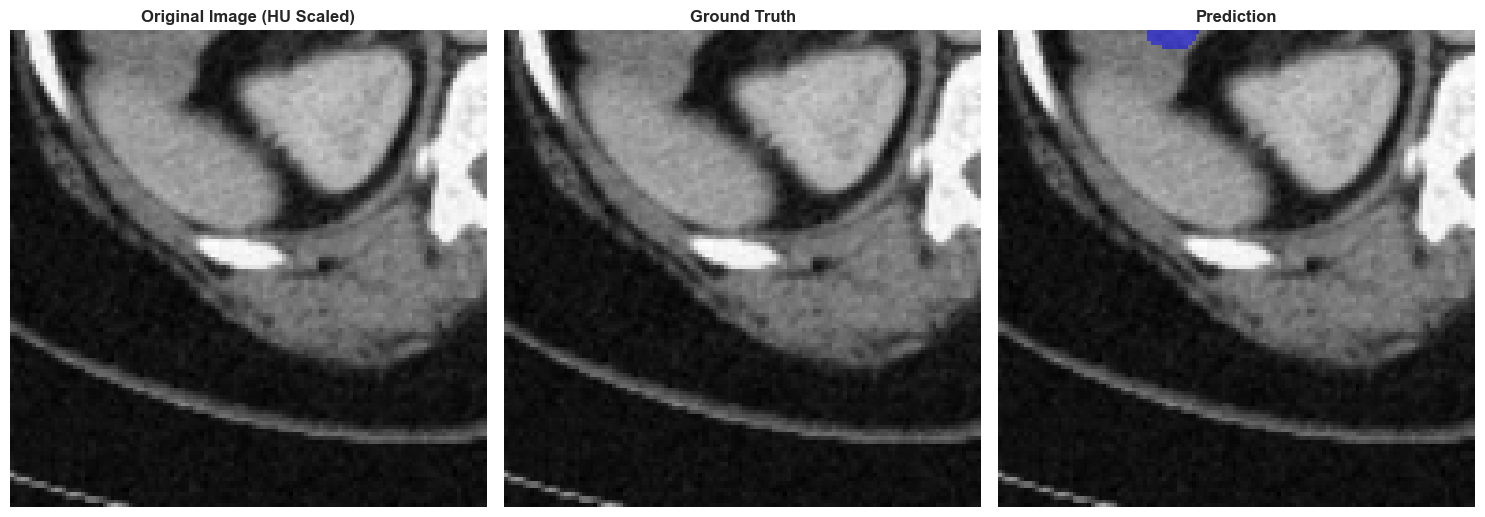

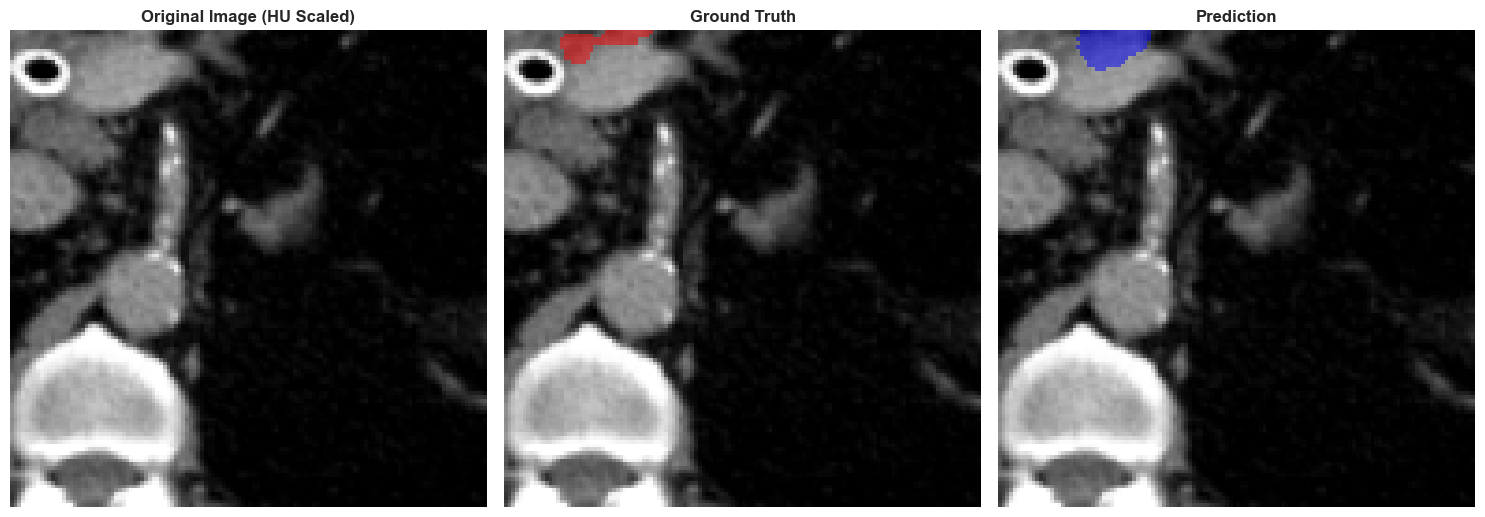

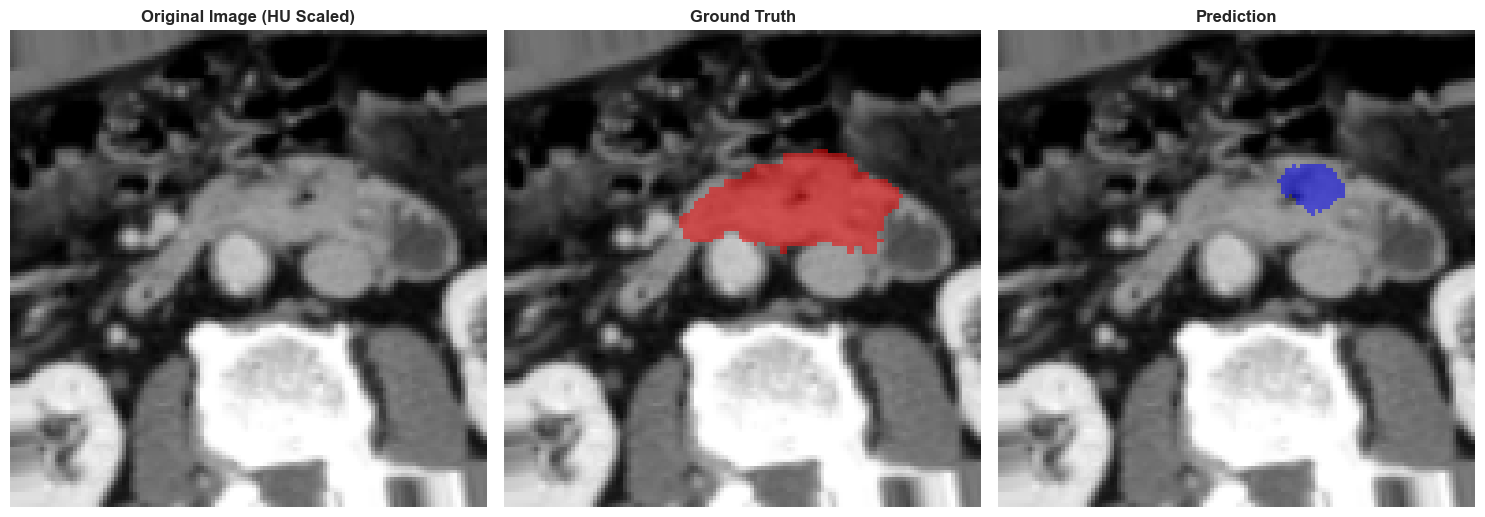

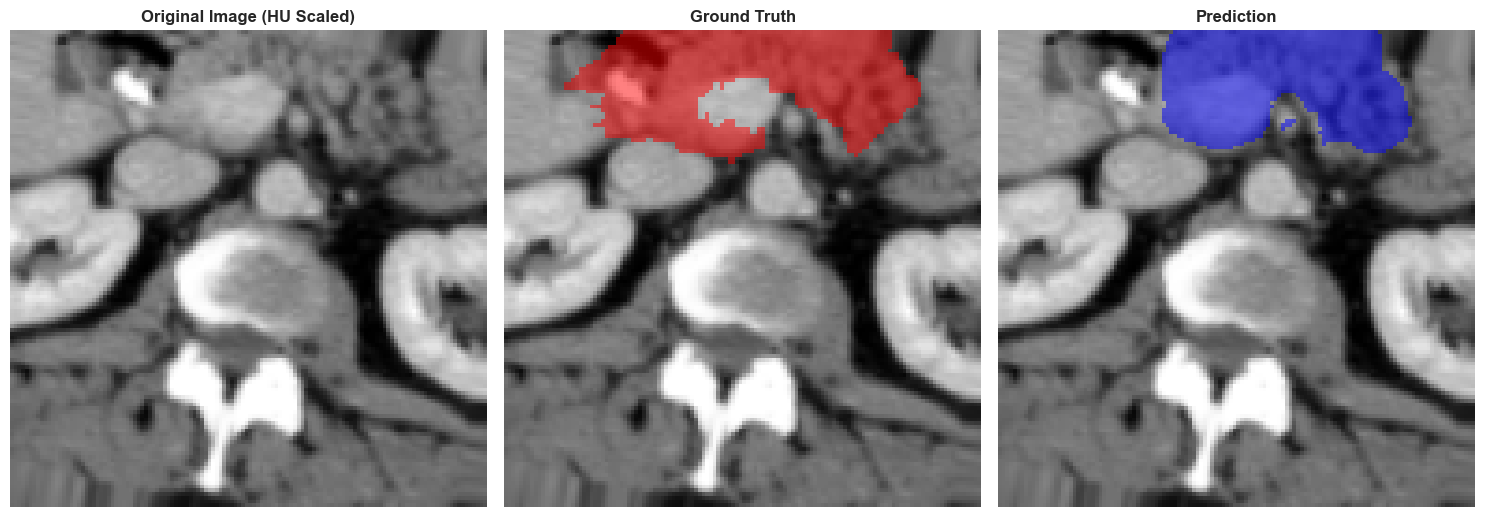

In [16]:
# pred
print("\nPlotting example predictions from test set...")
model.eval()
with torch.no_grad():
    for i, test_data_sample in enumerate(train_loader):
        if i >= 4: 
            break
        
        inputs, labels = test_data_sample["image"].to(device), test_data_sample["label"].to(device)
        
        if inputs.dim() == 4:
            inputs = inputs.unsqueeze(0)
        if labels.dim() == 4:
            labels = labels.unsqueeze(0)

        outputs = model(inputs)
        predicted_mask = torch.argmax(outputs, dim=1).unsqueeze(1) 
        
        
        plot_segmentation_predictions(
            image=inputs[0].cpu(), 
            ground_truth=labels[0].cpu(),
            prediction=predicted_mask[0].cpu(),
            save_path=os.path.join(root_dir, "results", f"prediction_sample_{i+1}.png")
        )
